# Mask R-CNN - Train on Solar Dataset


This notebook shows how to train Mask R-CNN on the solar dataset. It requires a GPU for faster processing.

## Imports for Colab

In [1]:
# Make sure the notebook will use tensorflow version 1.x
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
# Install keras version 2.1.0
!pip install keras==2.1.0

     |████████████████████████████████| 307kB 4.9MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.0 which is incompatible.
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [3]:
# Check if GPU is activated (if not, use top menu 'Change execution type')
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
# Clone Mask R-CNN repo
!git clone --quiet https://github.com/matterport/Mask_RCNN.git
print("Mask_RCNN successfuly cloned.")

Mask_RCNN successfuly cloned.


In [5]:
# Install Mask R-CNN dependencies
%cd /content/Mask_RCNN
!pip install -q PyDrive
!pip install -q -r requirements.txt
!python setup.py install

/content/Mask_RCNN
     |████████████████████████████████| 204kB 7.2MB/s 
     |████████████████████████████████| 163kB 62.4MB/s 
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.l

In [6]:
# Check the correct versions of tensorflow (1.15.2) and keras (2.1.0) have been loaded
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

1.15.2
2.1.0


Using TensorFlow backend.


In [0]:
# Import Mask RCNN
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [8]:
# Import solar.py
print("Please upload solar.py to Colab")
from google.colab import files
src = list(files.upload().values())[0]
open('solar.py','wb').write(src)
import solar

Please upload solar.py to Colab


Saving solar.py to solar.py
... done downloading pretrained model!


In [12]:
# Import dataset
# To import solar.zip from local disk, use side menu and then:
!unzip -q /content/solar.zip -d /content/Mask_RCNN
print("Successfuly unzipped dataset.")

Successfuly unzipped dataset.


In [0]:
# Other method: to mount dataset solar.zip from Google Drive, use code below
%cd /content/Mask_RCNN

fileId = '1p11kagop07-LyNyTIQ5_bDHx6I2TSDN9'

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

os.makedirs('dataset')
os.chdir('dataset')

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

In [0]:
# Other required imports
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [11]:
# Root directory of the project
ROOT_DIR = "/content/Mask_RCNN"

# Directory to save logs and trained model
os.makedirs('/content/Mask_RCNN/logs')
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to dataset
SOLAR_DIR = os.path.join(ROOT_DIR, "solar")

# Local path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_WEIGHTS_PATH):
    utils.download_trained_weights(COCO_WEIGHTS_PATH)

... done downloading pretrained model!


## Configurations

Model configurations are defined in `solar.py`.

In [13]:
config = solar.SolarConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     6
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 6
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [0]:
# Override solar.py configurations for local testing
# class TestConfig(Solar Config):
#     IMAGE_CHANNEL_COUNT = 4
# config = TestConfig()
# config.display

## Dataset

Load the train and val datasets and display samples.

In [14]:
# Training dataset
dataset_train = solar.SolarDataset()
dataset_train.load_solar(SOLAR_DIR, "train")
dataset_train.prepare()

print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

# Validation dataset
dataset_val = solar.SolarDataset()
dataset_val.load_solar(SOLAR_DIR, "val")
dataset_val.prepare()

print("\nImage Count: {}".format(len(dataset_val.image_ids)))
print("Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 175
Class Count: 2
  0. BG                                                
  1. solar array                                       

Image Count: 44
Class Count: 2
  0. BG                                                
  1. solar array                                       


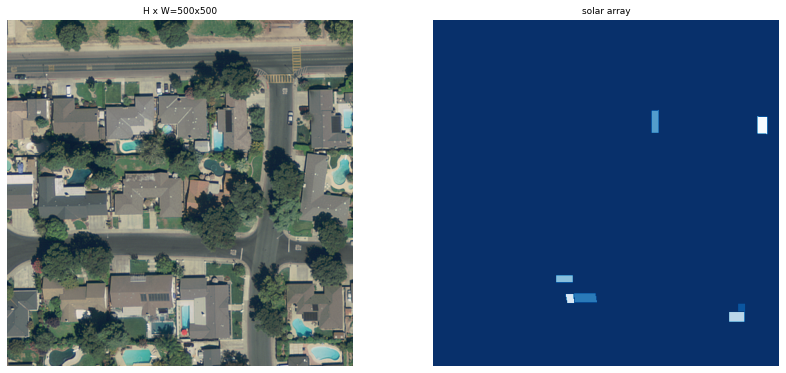

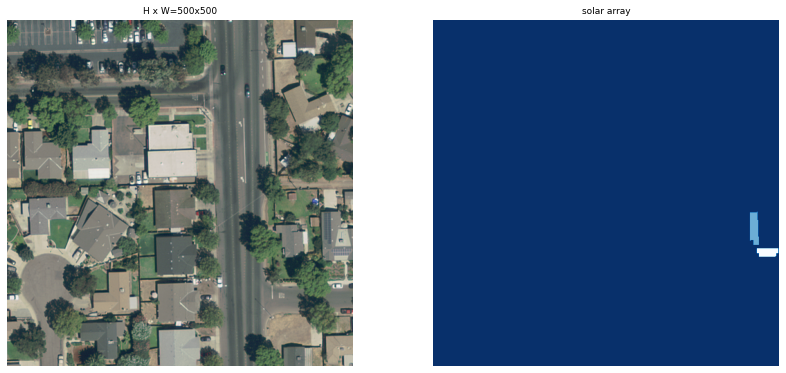

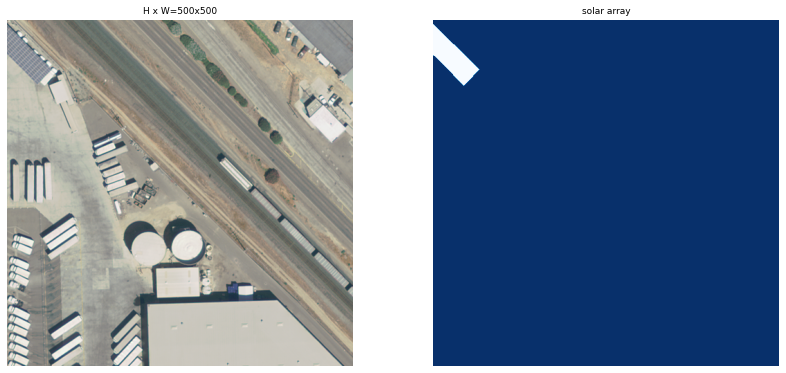

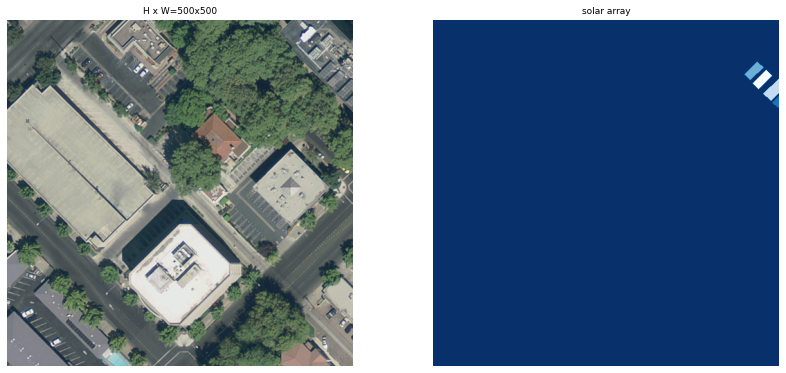

In [15]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)

## Create Model

In [0]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=DEFAULT_LOGS_DIR)

In [41]:
# Load selected weights
init_with = "last"

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
    print("Loaded model: ImageNet pre-trained weights")

elif init_with == "coco":
    # Remark: we skip layers that are different due to different nb of classes
    model.load_weights(COCO_WEIGHTS_PATH, by_name=True,
                        exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
    print("Loaded model: COCO pre-trained weights")

elif init_with == "last":
    # 1st option: load the last trained model and continue training
    model.load_weights(model.find_last(), by_name=True)
    # 2nd option: load a specific .h5 file
    #model.load_weights(os.path.join(ROOT_DIR, ".h5 file"), by_name=True)
    print("Loaded model: ", model.find_last())

Re-starting from epoch 1
Loaded model:  /content/Mask_RCNN/logs/solar20200430T1239/mask_rcnn_solar_0001.h5


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that do not use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `model.train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we could simply set `layers_to_train = "all"`, which passes `layers="all` to the `model.train()` function.

In [0]:
layers_to_train = "heads"
augment = False
epochs = 25

In [0]:
# Augmentations
if augment:
    # Set image augmentation parameters
    augmentation = iaa.SomeOf((0, 2), [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)]),
        iaa.Multiply((0.8, 1.2)),
        iaa.GaussianBlur(sigma=(0.0, 1.0))
    ])

In [43]:
# Set learning rate
lr = config.LEARNING_RATE/10 if layers_to_train == "all" else config.LEARNING_RATE
print(lr)

0.001


In [44]:
# Train selected layers/branches
print("Layers to train: {}.".format(layers_to_train))
if augment:
    model.train(dataset_train, dataset_val,
            learning_rate=lr,
            epochs=epochs,
            augmentation=augmentation,
            layers=layers_to_train)
if not augment:
    model.train(dataset_train, dataset_val,
            learning_rate=lr, 
            epochs=epochs, 
            layers=layers_to_train)

Layers to train: heads.

Starting at epoch 1. LR=0.001

Checkpoint Path: /content/Mask_RCNN/logs/solar20200430T1239/mask_rcnn_solar_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDist

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers 

Epoch 2/25
 99/100 [============================>.] - ETA: 1s - loss: 1.8364 - rpn_class_loss: 0.1000 - rpn_bbox_loss: 0.9272 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.4326 - mrcnn_mask_loss: 0.3604

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 330s 3s/step - loss: 1.8370 - rpn_class_loss: 0.0996 - rpn_bbox_loss: 0.9283 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.4322 - mrcnn_mask_loss: 0.3609 - val_loss: 2.0634 - val_rpn_class_loss: 0.0792 - val_rpn_bbox_loss: 0.9316 - val_mrcnn_class_loss: 0.0238 - val_mrcnn_bbox_loss: 0.5671 - val_mrcnn_mask_loss: 0.4617
Epoch 3/25
100/100 [==============================] - 97s 968ms/step - loss: 1.5212 - rpn_class_loss: 0.0894 - rpn_bbox_loss: 0.8272 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.2852 - mrcnn_mask_loss: 0.2970 - val_loss: 1.7311 - val_rpn_class_loss: 0.0822 - val_rpn_bbox_loss: 0.7237 - val_mrcnn_class_loss: 0.0190 - val_mrcnn_bbox_loss: 0.4528 - val_mrcnn_mask_loss: 0.4533
Epoch 4/25
100/100 [==============================] - 95s 952ms/step - loss: 1.3709 - rpn_class_loss: 0.0840 - rpn_bbox_loss: 0.7476 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.2374 - mrcnn_mask_loss: 0.2757 - val_loss: 1.7492 - val_rpn_class_loss: 0.

In [0]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(DEFAULT_LOGS_DIR, "mask_rcnn_solar.h5")
# model.keras_model.save_weights(model_path)

## Quick detection

This section only allows to quickly check detection performance. For more detailed model testing and performance indicators, please refer to the notebook `inspect_solar_model.ipynb`.

In [0]:
class InferenceConfig(solar.SolarConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

In [46]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=DEFAULT_LOGS_DIR)

# Load trained weights (either last model or .h5 file path)
model_path = model.find_last()
#model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model.load_weights(model_path, by_name=True)
print("Loaded model:", model_path)

Re-starting from epoch 25
Loaded model: /content/Mask_RCNN/logs/solar20200430T1239/mask_rcnn_solar_0025.h5


In [63]:
# Pick random image in validation set
test_id = np.random.choice(dataset_val.image_ids)
print("Image id :", test_id)
info = dataset_val.image_info[test_id]
# print("Image name :", info["img_name"])
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(
    dataset_val, inference_config, test_id, use_mini_mask=False)

Image id : 35


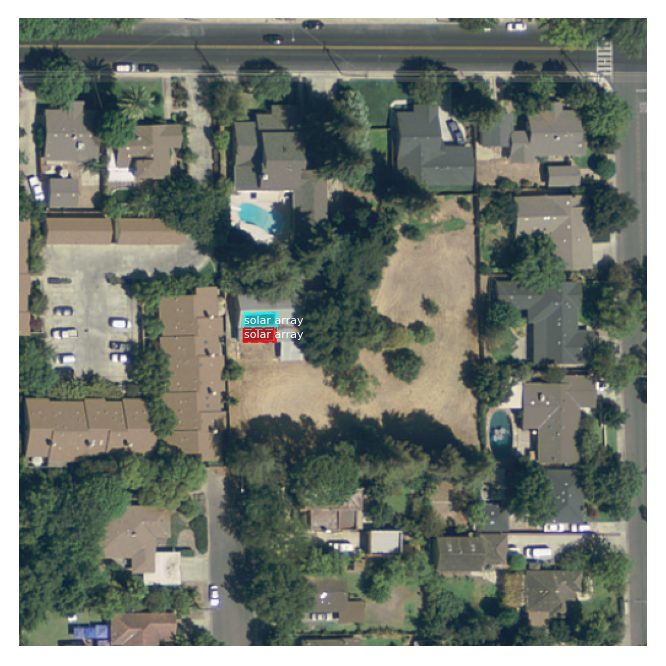

In [64]:
# Visualize ground truth
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(12, 12))

In [65]:
# Run detection
yhat = model.detect([original_image], verbose=1)[0] # verbose=0
n_solar = yhat['masks'].shape[2]
print("Nb of solar arrays detected: ", n_solar)

Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  147.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
Nb of solar arrays detected:  1


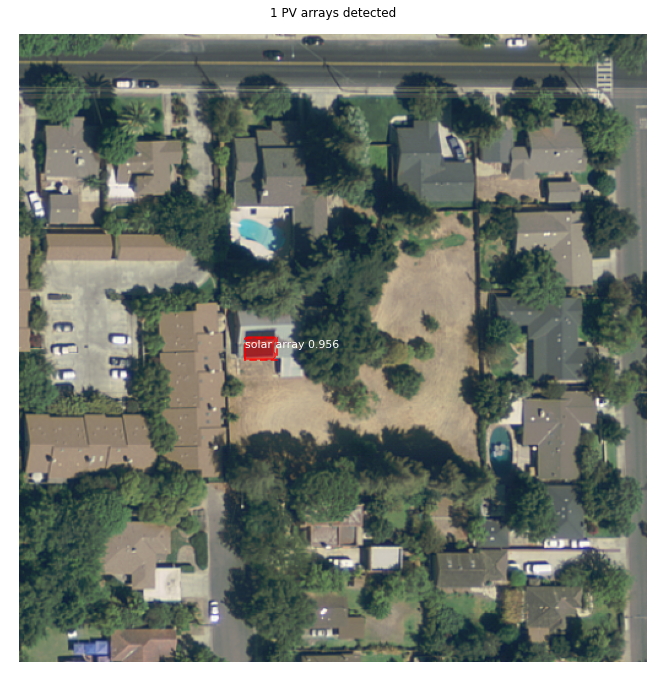

In [66]:
# Display detection
visualize.display_instances(original_image, yhat['rois'], yhat['masks'],
                            yhat['class_ids'], dataset_val.class_names,
                            yhat['scores'], figsize=(12, 12),
                            title="{} PV arrays detected".format(n_solar))

In [0]:
# Compute surface over detected masks
pv_surface = solar.compute_mask_to_surface(yhat['masks'])

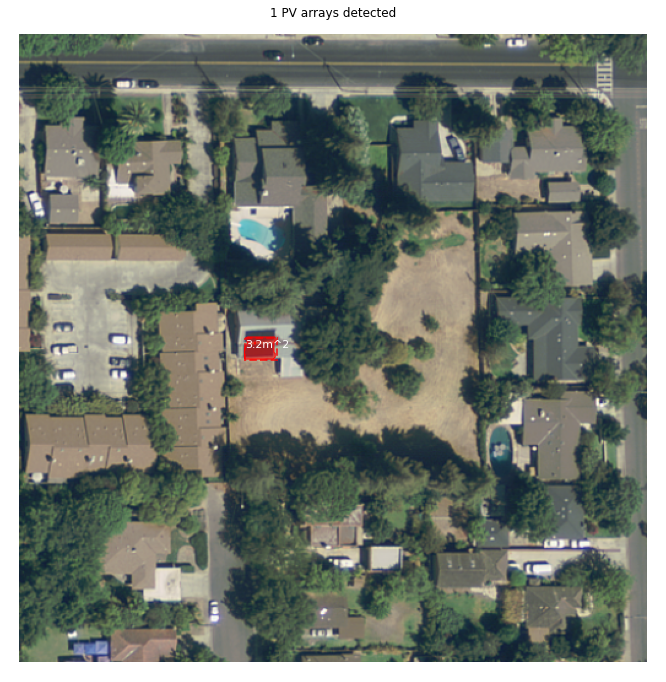

In [69]:
# Display prediction, with surface annotation
pv_size_annot = [str(round(x,1))+"m^2" for x in pv_surface]
visualize.display_instances(original_image, yhat['rois'], yhat['masks'],
                            yhat['class_ids'], dataset_val.class_names,
                            captions=pv_size_annot, 
                            title="{} PV arrays detected".format(n_solar),
                            figsize=(12, 12))

## Quick evaluation

Similarly, for more detailed model evaluation, please refer to the notebook `inspect_solar_model.ipynb`.

In [70]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.2333333373069763
